<a href="https://colab.research.google.com/github/jgalazka/ERCC_analysis/blob/main/GLDS-235-Liver/GLDS_235_Liver_ERCC_02032021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeneLab ERCC spike-in analysis notebook

This notebook contains an analysis of RNA-seq counts data generated from ERCC spike-ins.

Here GLDS-235 Liver is analyzed


## Section 1: Setting up the notebook

In [ ]:
# Set-up notebook to allow inline running of R code
# Having done this, any code block starting with %RR will be run as R
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [24]:
# import python packages
import pandas as pd
import numpy as np
from urllib.request import urlopen, quote, urlretrieve
from json import loads
from re import search
import zipfile
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [ ]:
# Install R libraries necessary
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("erccdashboard")

In [ ]:
# Load R libraries
%%R
library(erccdashboard)

In [2]:
# Function to pull metadata zip from GeneLab
# Credit to Kirill Grigorev
GENELAB_ROOT = "https://genelab-data.ndc.nasa.gov"
GLDS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/data/"
FILELISTINGS_URL_PREFIX = GENELAB_ROOT + "/genelab/data/study/filelistings/"
ISA_ZIP_REGEX = r'.*_metadata_.*[_-]ISA\.zip$'

def read_json(url):
    with urlopen(url) as response:
        return loads(response.read().decode())

def get_isa(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    isa_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(ISA_ZIP_REGEX, entry["file_name"])
    ]
    if len(isa_entries) == 0:
        raise ValueError("Unexpected: no ISAs found")
    elif len(isa_entries) > 1:
        raise ValueError("Unexpected: multiple files match the ISA regex")
    else:
        entry = isa_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

In [3]:
# Function to pull unnormalized counts from GeneLab
# Credit to Kirill Grigorev

RAW_COUNTS_REGEX = r'.*_rna_seq_Unnormalized_Counts.csv'

def get_rawcounts(accession):
    glds_json = read_json(GLDS_URL_PREFIX + accession)
    try:
        _id = glds_json[0]["_id"]
    except (AssertionError, TypeError, KeyError, IndexError):
        raise ValueError("Malformed JSON?")
    raw_counts_entries = [
        entry for entry in read_json(FILELISTINGS_URL_PREFIX + _id)
        if search(RAW_COUNTS_REGEX, entry["file_name"])
    ]
    if len(raw_counts_entries) == 0:
        raise ValueError("Unexpected: no Raw Counts found")
    elif len(raw_counts_entries) > 1:
        raise ValueError("Unexpected: multiple files match the Raw Counts regex")
    else:
        entry = raw_counts_entries[0]
        version = entry["version"]
        url = GENELAB_ROOT + entry["remote_url"] + "?version={}".format(version)
        alt_url = (
            GENELAB_ROOT + "/genelab/static/media/dataset/" +
            quote(entry["file_name"]) + "?version={}".format(version)
        )
        return entry["file_name"], version, url, alt_url

## Get and parse data and metadata
Get ISA, counts, and ERCC data.

In [4]:
accession = 'GLDS-235' # Change this as necessary
isaurl = get_isa(accession)[3]
filehandle, _ = urlretrieve(isaurl)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist() # Print contents of zip file. Pick relevant one from list

['s_Freezing Study_Liver.txt',
 'i_Investigation.txt',
 'a_freezing_study_liver_transcription_profiling_RNA_Sequencing_(RNA-Seq).txt']

In [5]:
sample_file = zip_file_object.namelist()[0]
file = zip_file_object.open(sample_file)
sample_table = pd.read_csv(zip_file_object.open(sample_file), sep='\t')

assay_file = zip_file_object.namelist()[2]
file = zip_file_object.open(assay_file)
assay_table = pd.read_csv(zip_file_object.open(assay_file), sep='\t')

In [6]:
sample_table.head()

,Source Name,Characteristics[Organism],Term Source REF,Term Accession Number,Comment[Animal Source],Characteristics[Strain],Characteristics[Genotype],"Characteristics[sex,http://purl.obolibrary.org/obo/PATO_0000047,EFO]",Term Source REF.1,Term Accession Number.1,"Characteristics[age,http://www.ebi.ac.uk/efo/EFO_0000246,EFO]",Unit,Term Source REF.2,Term Accession Number.2,Parameter Value[Habitat],Term Source REF.3,Term Accession Number.3,"Characteristics[diet,http://www.ebi.ac.uk/efo/EFO_0002755,EFO]",Term Source REF.4,Term Accession Number.4,Parameter Value[Feeding Schedule],Term Source REF.5,Term Accession Number.5,Protocol REF,Factor Value[Euthanasia Method],Term Source REF.6,Term Accession Number.6,Protocol REF.1,Sample Name,Factor Value[Carcass Preservation Method],Term Source REF.7,Term Accession Number.7,Factor Value[Tissue Preservation Method],Term Source REF.8,Term Accession Number.8,Factor Value[Dissection Condition],Term Source REF.9,Term Accession Number.9,Factor Value[Tissue Homogenate Preservation Time at -80C in RLT Buffer],Unit.1,Term Source REF.10,Term Accession Number.10,Material Type,Term Source REF.11,Term Accession Number.11,Comment[Carcass Weight (g)]
0,M31,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,22.4
1,M32,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,23.7
2,M33,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,25.7
3,M34,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanasia,CO2,NaN,NaN,sample collection,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Dry Ice,MESH,http://purl.bioontology.org/ontology/MESH/D004367,NaN,NaN,NaN,Carcass,NaN,NaN,0,day,UO,http://purl.obolibrary.org/obo/UO_0000033,left lobe of liver,UBERON,http://purl.obolibrary.org/obo/UBERON_0001115,22.5
4,M31,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,Jackson Laboratory,C57BL/6J,WT,female,EFO,http://purl.obolibrary.org/obo/PATO_0000383,20-21,week,UO,http://purl.obolibrary.org/obo/UO_0000034,vivarium,ENVO,http://purl.obolibrary.org/obo/ENVO_00010622,standard chow,NaN,NaN,ad libitum,NaN,NaN,Euthanas

In [7]:
assay_table.head()

,Sample Name,Protocol REF,Parameter Value[QA Instrument],Parameter Value[QA Assay],Parameter Value[QA Score],Unit,Term Source REF,Term Accession Number,Extract Name,Protocol REF.1,Parameter Value[Spike-in Quality Control],Term Source REF.1,Term Accession Number.1,Parameter Value[Spike-in Mix Number],Term Source REF.2,Term Accession Number.2,Protocol REF.2,Parameter Value[library selection],Parameter Value[library layout],Parameter Value[stranded],Parameter Value[Library QA Instrument],Term Source REF.3,Term Accession Number.3,Parameter Value[Library QA Assay],Term Source REF.4,Term Accession Number.4,Parameter Value[Fragment Size],Unit.1,Term Source REF.5,Term Accession Number.5,Protocol REF.3,Parameter Value[sequencing instrument],"Parameter Value[Read Length,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C153362,NCIT]",Unit.2,Term Source REF.6,Term Accession Number.6,Parameter Value[base caller],Assay Name,Parameter Value[rRNA Contamination],Unit.3,...,Term Accession Number.7,"Parameter Value[Read Depth,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C155320,NCIT]",Unit.4,Term Source REF.8,Term Accession Number.8,Raw Data File,Characteristics[Fastqc File Names],Term Source REF.9,Term Accession Number.9,Characteristics[MultiQC File Names],Term Source REF.10,Term Accession Number.10,Protocol REF.4,"Characteristics[trimmed sequence data,http://purl.obolibrary.org/obo/OBI_0002569,OBI]",Term Source REF.11,Term Accession Number.11,Characteristics[Trimmed Sequence Data Fastqc File],Term Source REF.12,Term Accession Number.12,Characteristics[Trimmed Sequence Data Multiqc File],Term Source REF.13,Term Accession Number.13,Characteristics[Trimmed Report],Term Source REF.14,Term Accession Number.14,"Characteristics[aligned sequence data,http://purl.obolibrary.org/obo/OBI_0002580,OBI]",Term Source REF.15,Term Accession Number.15,Characteristics[Alignment Logs],Term Source REF.16,Term Accession Number.16,Characteristics[Raw Counts Data File],Term Source REF.17,Term Accession Number.17,Characteristics[Normalized Counts Data File],Term Source REF.18,Term Accession Number.18,"Characteristics[differential expression analysis data transformation,http://purl.obolibrary.org/obo/OBI_0000650,OBI]",Term Source REF.19,Term Accession Number.19
0,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,7.1,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31_RNA_ALQ2,spike-in control protocol,ERCC ExFold RNA Spike-In Mix,NaN,NaN,Mix 1,NaN,NaN,library construction,PCR,PAIRED,Stranded,Agilent 4200 TapeStation,NaN,NaN,D1000 ScreenTape,NaN,NaN,332,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,nucleic acid sequencing,Illumina NovaSeq 6000,149,base pair,UO,http://purl.obolibrary.org/obo/UO_0000244,bcl2fastq,rna-seq,0.16,percent,...,http://purl.obolibrary.org/obo/UO_0000187,84828509,read,SO,http://purl.obolibrary.org/obo/SO_0000150,GLDS-235_rna-seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,GLDS-235_rna-seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,"GLDS-235_rna-seq_raw_multiqc_data.zip, GLDS-23...",NaN,NaN,GeneLab RNAseq data processing protocol,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,"GLDS-235_rna_seq_trimmed_multiqc_report.html, ...",NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,GLDS-235_rna_seq_Mmus_C57-6J_LVR_CO2_C_DI_ext1...,NaN,NaN,"GLDS-235_rna_seq_Normalized_Counts.csv, GLDS-2...",NaN,NaN,"GLDS-235_rna_seq_contrasts.csv, GLDS-235_rna_s...",NaN,NaN
1,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,nucleic acid extraction,Agilent 2100 Bioanalyzer,RNA 6000 Nano Assay,6.9,RNA Integrity Number,NCIT,http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus...,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32_RNA_ALQ1,spike-in control protocol,ERCC ExFold RNA Spi

In [8]:
# Get raw counts table
raw_counts_file = get_rawcounts('GLDS-235')[3]
raw_counts_table = pd.read_csv(raw_counts_file, index_col=0)
raw_counts_table.index.rename('Gene_ID', inplace=True)
raw_counts_table.head()

,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep6_M36,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep6_M12,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep1_M13,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep3_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep5_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep1_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep3_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep5_M18,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep5_M23,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep6_M24,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep5_M23,Mmus_C57-6J_LVR_Euth_I_DI_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_DI_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_DI_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_DI_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_DI_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_DI_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_LN2_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_LN2_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_LN2_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_LN2_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_LN2_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_LN2_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep6_M6,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep5_M29,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep6_M30
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,12.0,13.0,18.0,17.0,10.0,4.0,5.0,0.0,6.0,3.0,2.0,43.0,1.0,39.0,7.0,7.0,12.0,44.0,14.0,4.0,20.0,2.0,7.0,5.0,5.0,13.0,17.0,23.0,13.0,16.0,17.0,9.0,9.0,15.0,13.0,6.0,2.0,13.0,1.0,16.0,1.0,11.0,0.0,3.0,1.0,6.0,6.0,33.0,2.0,7.0,4.0,2.0,5.0,7.0,8.0,6.0,2.0,10.0,1.0,11.0,2.0,16.0,4.0,5.0,6.0,12.0,48.0,6.0,43.0,12.0,4.0,1.0,7.0,9.0,2.0
ENSMUSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,

In [9]:
# Get ERCC counts
ercc_counts = raw_counts_table[raw_counts_table.index.str.contains('^ERCC-')]
ercc_counts.head()

,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep6_M36,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep6_M12,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep1_M13,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep3_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep5_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep1_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep3_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep5_M18,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep5_M23,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep6_M24,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep5_M23,Mmus_C57-6J_LVR_Euth_I_DI_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_DI_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_DI_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_DI_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_DI_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_DI_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_LN2_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_LN2_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_LN2_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_LN2_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_LN2_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_LN2_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep6_M6,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep5_M29,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep6_M30
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,1150.0,0.0,1833.0,3402.0,2085.0,99.0,652.0,104.0,1222.0,55.0,327.0,0.0,253.0,4853.0,447.0,2116.0,943.0,6163.0,1758.0,724.0,1391.0,257.0,518.0,201.0,215.0,1485.0,0.0,2707.0,5356.0,3715.0,3605.0,581.0,2640.0,1530.0,1058.0,217.0,217.0,0.0,210.0,3715.0,191.0,3101.0,396.0,726.0,1214.0,1073.0,2136.0,8205.0,261.0,814.0,341.0,1154.0,328.0,680.0,1675.0,745.0,367.0,245.0,333.0,659.0,437.0,1137.0,260.0,412.0,714.0,2335.0,0.0,779.0,6436.0,1304.0,150.0,277.0,227.0,914.0,281.0
ERCC-00003,168.0,0.0,178.0,191.0,138.0,12.0,44.0,7.0,87.0,7.0,20.0,0.0,23.0,479.0,29.0,121.0,201.0,656.0,147.0,45.0,129.0,27.0,43.0,22.0,18.0,210.0,0.0,245.0,465.0,285.0,211.0,41.0,154.0,124.0,44.0,34.0,20.0,0.0,23.0,298.0,14.0,174.0,25.0,69.0,65.0,79.0,226.0,613.0,19.0,40.0,14.0,84.0,18.0,57.0,116.0,56.0,15.0,24.0,20.0,113.0,26.0,126.0,20.0,53.0,34.0,141.0,

In [10]:
# Get ERCC files
ercc_url = 'https://assets.thermofisher.com/TFS-Assets/LSG/manuals/cms_095046.txt'
filehandle, _ = urlretrieve(ercc_url)
ercc_table = pd.read_csv(filehandle, '\t')
ercc_table.head()

,Re-sort ID,ERCC ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
0,1,ERCC-00130,A,30000.00,7500.0000,4.0,2.0
1,2,ERCC-00004,A,7500.00,1875.0000,4.0,2.0
2,3,ERCC-00136,A,1875.00,468.7500,4.0,2.0
3,4,ERCC-00108,A,937.50,234.3750,4.0,2.0
4,5,ERCC-00116,A,468.75,117.1875,4.0,2.0


## Single Sample ERCC Analysis
Because samples may be combined by users outside of their original study, it is useful to have ERCC metrics that can be calculated from single samples. These could include: limit of detection, dynamic range, R^2 from measured vs expected plot, etc.

In [11]:
# Limit of detection. Lowest abundance ERCC detected. Report attomoles/ul
# Annotate ERCC counts table with Mix 1 and Mix 2 concentrations
# Build dictionary of Mix 1 and Mix 2 values for each ERCC
# Make a dictionary for ERCC concentrations for each mix
mix1_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 1 (attomoles/ul)']))
mix2_conc_dict = dict(zip(ercc_table['ERCC ID'], ercc_table['concentration in Mix 2 (attomoles/ul)']))

In [12]:
# get samples that use mix 1 and mix 2
mix1_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 1']['Sample Name']
mix2_samples = assay_table[assay_table['Parameter Value[Spike-in Mix Number]'] == 'Mix 2']['Sample Name']

In [13]:
ercc_counts_mix_1 = ercc_counts[mix1_samples]
ercc_counts_mix_1['ERCC conc'] = ercc_counts_mix_1.index.map(mix1_conc_dict)
ercc_counts_mix_1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep6_M36,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep6_M12,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep1_M13,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep3_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep5_M17,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep1_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep3_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep5_M18,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep5_M23,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep4_M22,Mmus_C57-6J_LVR_Euth_I_DI_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_DI_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_DI_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_LN2_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_LN2_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_LN2_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep5_M5,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep6_M30,ERCC conc
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,1150.0,1833.0,99.0,104.0,55.0,327.0,253.0,447.0,943.0,1758.0,1391.0,257.0,201.0,1485.0,2707.0,3715.0,581.0,1530.0,217.0,217.0,210.0,191.0,726.0,1073.0,261.0,341.0,328.0,680.0,745.0,245.0,659.0,1137.0,412.0,2335.0,779.0,150.0,227.0,281.0,15000.000000
ERCC-00003,168.0,178.0,12.0,7.0,7.0,20.0,23.0,29.0,201.0,147.0,129.0,27.0,22.0,210.0,245.0,285.0,41.0,124.0,34.0,20.0,23.0,14.0,69.0,79.0,19.0,14.0,18.0,57.0,56.0,24.0,113.0,126.0,53.0,141.0,42.0,10.0,17.0,26.0,937.500000
ERCC-00004,568.0,725.0,25.0,18.0,29.0,87.0,70.0,106.0,582.0,591.0,533.0,138.0,77.0,781.0,894.0,1137.0,167.0,465.0,128.0,74.0,79.0,56.0,260.0,444.0,55.0,74.0,42.0,164.0,156.0,88.0,465.0,584.0,191.0,680.0,226.0,40.0,91.0,99.0,7500.000000
ERCC-00009,72.0,109.0,18.0,17.0,5.0,24.0,15.0,22.0,44.0,99.0,60.0,18.0,19.0,71.0,118.0,143.0,31.0,95.0,19.0,11.0,19.0,14.0,36.0,59.0,14.0,24.0,24.0,35.0,30.0,15.0,33.0,64.0,19.0,131.0,28.0,10.0,17.0,26.0,937.500000
ERCC-00012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114441


In [14]:
ercc_counts_mix_2 = ercc_counts[mix2_samples]
ercc_counts_mix_2['ERCC conc'] = ercc_counts_mix_2.index.map(mix2_conc_dict)
ercc_counts_mix_2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32,Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33,Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9,Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8,Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16,Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15,Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep6_M24,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep1_M19,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep3_M21,Mmus_C57-6J_LVR_Euth_C_RNAlat_ext2_Rep5_M23,Mmus_C57-6J_LVR_Euth_I_DI_Rep1_M1,Mmus_C57-6J_LVR_Euth_I_DI_Rep3_M3,Mmus_C57-6J_LVR_Euth_I_DI_Rep5_M5,Mmus_C57-6J_LVR_Euth_I_LN2_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_LN2_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_LN2_Rep6_M6,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep2_M2,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep4_M4,Mmus_C57-6J_LVR_Euth_I_RNAlat_Rep6_M6,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep2_M26,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext1_Rep4_M28,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep1_M25,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep3_M27,Mmus_C57-6J_LVR_Ket-Xyl_C_DI_ext2_Rep5_M29,ERCC conc
Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ERCC-00002,0.0,3402.0,2085.0,652.0,1222.0,0.0,4853.0,2116.0,6163.0,724.0,518.0,215.0,0.0,5356.0,3605.0,2640.0,1058.0,0.0,3715.0,3101.0,396.0,1214.0,2136.0,8205.0,814.0,1154.0,1675.0,367.0,333.0,437.0,260.0,714.0,0.0,6436.0,1304.0,277.0,914.0,30000.000000
ERCC-00003,0.0,191.0,138.0,44.0,87.0,0.0,479.0,121.0,656.0,45.0,43.0,18.0,0.0,465.0,211.0,154.0,44.0,0.0,298.0,174.0,25.0,65.0,226.0,613.0,40.0,84.0,116.0,15.0,20.0,26.0,20.0,34.0,0.0,469.0,67.0,33.0,62.0,1875.000000
ERCC-00004,0.0,68.0,65.0,16.0,20.0,0.0,178.0,50.0,215.0,17.0,15.0,5.0,0.0,181.0,73.0,57.0,19.0,0.0,118.0,55.0,7.0,26.0,84.0,250.0,18.0,39.0,29.0,12.0,7.0,25.0,9.0,13.0,0.0,193.0,25.0,12.0,18.0,1875.000000
ERCC-00009,0.0,54.0,32.0,8.0,23.0,0.0,118.0,37.0,143.0,15.0,7.0,3.0,0.0,122.0,75.0,51.0,12.0,0.0,77.0,48.0,4.0,19.0,54.0,135.0,13.0,20.0,33.0,4.0,8.0,9.0,8.0,13.0,0.0,147.0,19.0,9.0,24.0,937.500000
ERCC-00012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171661


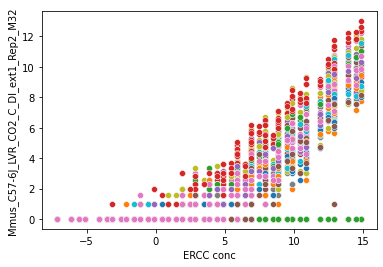

In [15]:
columns = ercc_counts_mix_2.columns
for i in range(0, len(columns)-1):
  #print(columns[i])
  sns.scatterplot(x=np.log2(ercc_counts_mix_2['ERCC conc']), y=np.log2(ercc_counts_mix_2[columns[i]]+1))

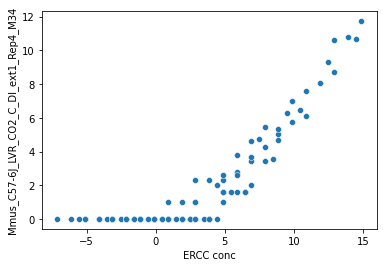

In [16]:
columns = ercc_counts_mix_2.columns
counts = ercc_counts_mix_2[columns[1]]
sns.scatterplot(x=np.log2(ercc_counts_mix_2['ERCC conc']), y=np.log2(counts+1))

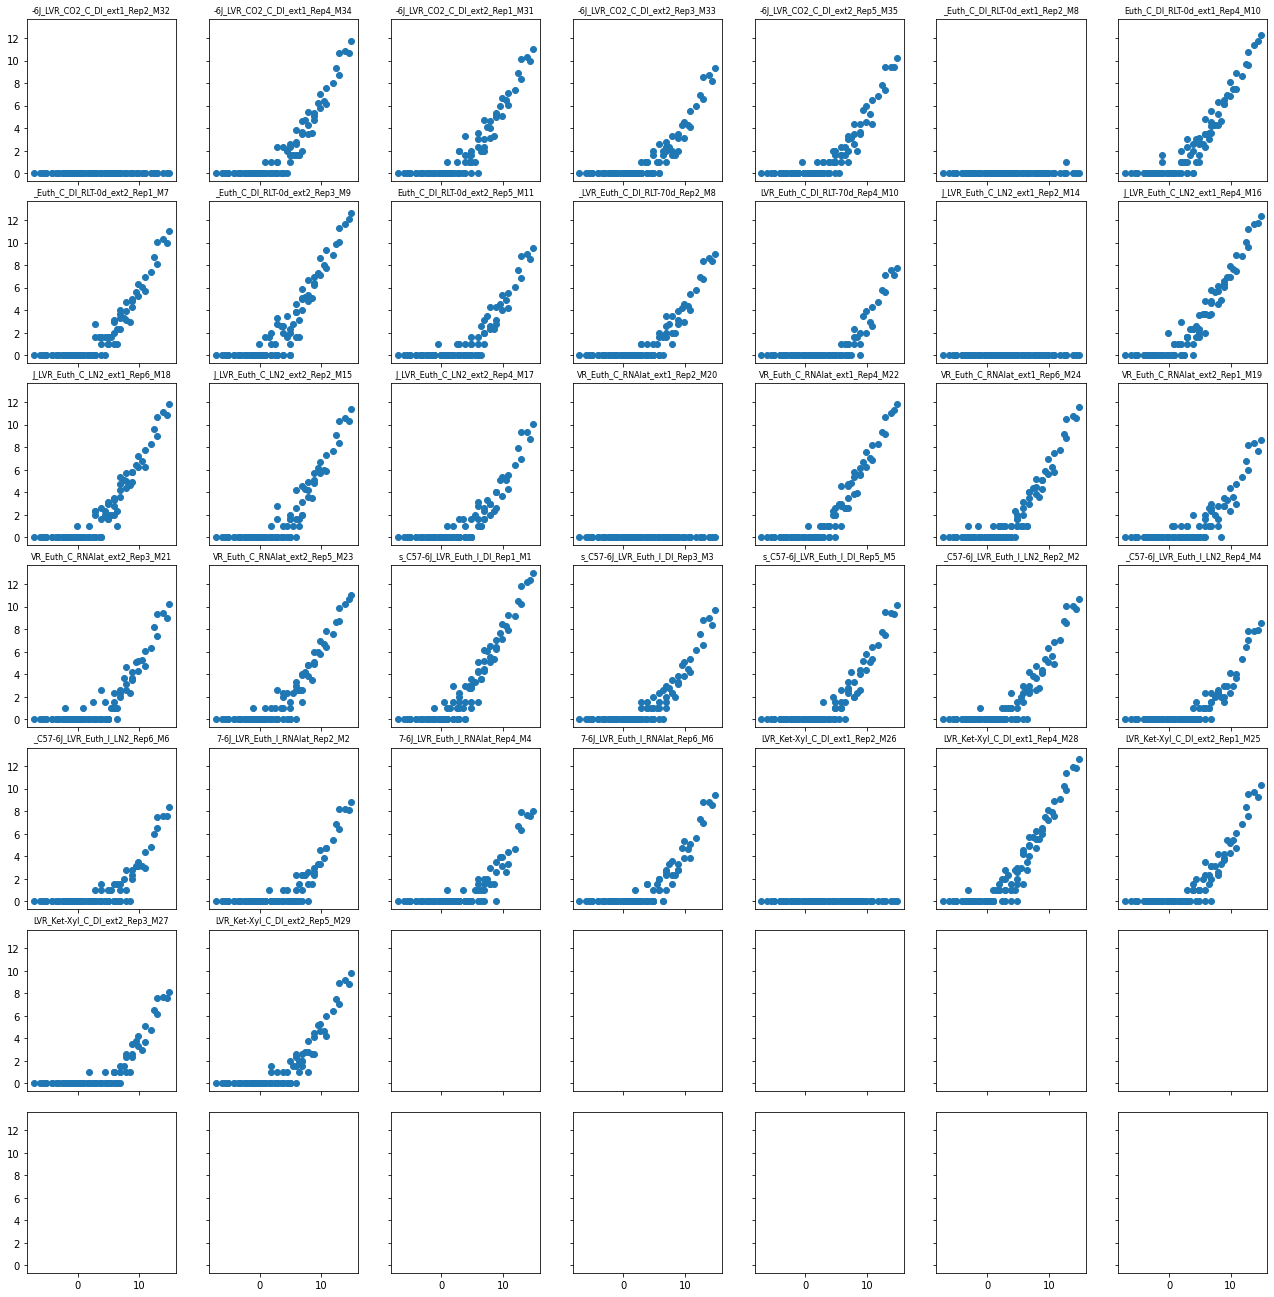

In [60]:
columns = ercc_counts_mix_2.columns
counts = ercc_counts_mix_2[columns[1]]

# set-up plot grid
side_size = np.int(np.ceil(np.sqrt(len(columns)-1)))# calculate grid side size. take sqrt of total plots and round up.
fig, axs = plt.subplots(side_size, side_size, figsize=(18,18), sharex='all', sharey='all')
fig.tight_layout()

counter = 0
for ax in axs.flat:
    if(counter < len(columns)-1):
      ax.scatter(x=np.log2(ercc_counts_mix_2['ERCC conc']), y=np.log2(ercc_counts_mix_2[columns[counter]]+1))
      ax.set_title(columns[counter][-30:], fontsize=8)
    else:
      pass
    counter = counter + 1

In [61]:
print(columns)

Index(['Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep2_M32',
       'Mmus_C57-6J_LVR_CO2_C_DI_ext1_Rep4_M34',
       'Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep1_M31',
       'Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep3_M33',
       'Mmus_C57-6J_LVR_CO2_C_DI_ext2_Rep5_M35',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep2_M8',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext1_Rep4_M10',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep1_M7',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep3_M9',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-0d_ext2_Rep5_M11',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep2_M8',
       'Mmus_C57-6J_LVR_Euth_C_DI_RLT-70d_Rep4_M10',
       'Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep2_M14',
       'Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep4_M16',
       'Mmus_C57-6J_LVR_Euth_C_LN2_ext1_Rep6_M18',
       'Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep2_M15',
       'Mmus_C57-6J_LVR_Euth_C_LN2_ext2_Rep4_M17',
       'Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep2_M20',
       'Mmus_C57-6J_LVR_Euth_C_RNAlat_ext1_Rep4_M22',
     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


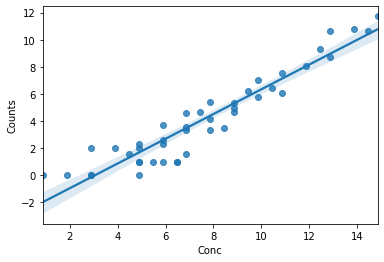

In [17]:
counts = ercc_counts_mix_2[columns[1]]
counts.index.rename('Gene_ID', inplace=True)
countsdf = pd.DataFrame(counts)
countsdf
nonzero_counts = countsdf[ercc_counts_mix_2[columns[1]] > 0]
nonzero_counts['Conc'] = nonzero_counts.index.map(mix2_conc_dict)
nonzero_counts.columns = ['Counts','Conc']
nonzero_counts
sns.regplot(np.log2(nonzero_counts['Conc']), y=np.log2(nonzero_counts['Counts']))

In [18]:
slope, intercept, r, p, se = linregress(np.log2(nonzero_counts['Conc']), y=np.log2(nonzero_counts['Counts']))
print(r)

0.948282986908978


In [19]:
# Measure minimum detected
nonzero_counts.sort_values('Conc')
min = nonzero_counts.sort_values('Conc')['Conc'][0]
min

1.83105469

In [20]:
# Measure maximum detected
nonzero_counts.sort_values('Conc')
max = nonzero_counts.sort_values('Conc', ascending=False)['Conc'][0]
max

30000.0

In [21]:
dynamic_range = max / min
dynamic_range

16383.99997763038

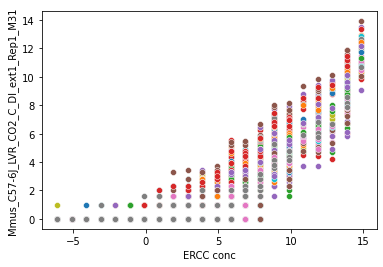

In [22]:
columns = ercc_counts_mix_1.columns
for i in range(0, len(columns)-1):
  #print(columns[i])
  sns.scatterplot(x=np.log2(ercc_counts_mix_1['ERCC conc']), y=np.log2(ercc_counts_mix_1[columns[i]]+1))

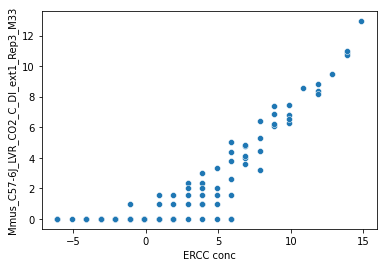

In [23]:
columns = ercc_counts_mix_1.columns
sns.scatterplot(x=np.log2(ercc_counts_mix_1['ERCC conc']), y=np.log2(ercc_counts_mix_1[columns[1]]+1))

## Full Study ERCC Analysis
In some studies, Mix 1 and Mix 2 are added to samples in a way that allows the power of a study to be evaluated. For example, all flight samples may contain Mix 1 while all ground contain Mix 2. In this case, using the ERCC Dashboard package allows an assessment of DE analysis between flight and ground by using the know ratios of transcripts in the ERCC Mix 1 and Mix 2 standards.